In [1]:
import os
import os.path as op
import boto3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
from diff_classifier import aws
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import numpy.ma as ma
from skimage import morphology
from scipy.ndimage.morphology import distance_transform_edt as Euclidean

First, download the necessary files from Amazon's s3 storage and assign them a name.

In [2]:
s3_bucket = 'mckenna.data'
s3_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
s3_img_filename = '{}_z_stack_MaxIP.tif'.format(prefix)
s3_feat_filename = "features_{}.csv".format(prefix)
aws.download_s3('{}/{}'.format(s3_folder,s3_feat_filename), s3_feat_filename, bucket_name=s3_bucket)
feat_name = s3_feat_filename
feat_df = pd.read_csv(feat_name)
aws.download_s3('{}/{}'.format(s3_folder,s3_img_filename), s3_img_filename, bucket_name = s3_bucket)
img = skimage.io.imread(s3_img_filename)

In [3]:
def PNN_binning(raw_img, input_df, num_bins=7, threshold='Otsu', min_obj_size=3000, bin_cuts=[0,3.57,7.14,14.28,142.8,714.3], \
                feat='Deff1', box_plot=True):
    
    
    # First, you have to scale the PNN confocal image so it aligns with the size of the MPT video
    # (usually, it must be scaled from a 512x512 image to a 2048x2048 image)
    img_scaled = resize(raw_img[0,:,:],(2048,2048))
    scaled_plot = plt.imshow(img_scaled, cmap='gray')
    plt.show()
    
    # this thresholds the scaled image using the user-input threshold type, converting the image to a binary
    
    if threshold == 'Otsu':
        thresh = skimage.filters.threshold_otsu(img_scaled)
    elif threshold == 'Mean':
        thresh = skimage.filters.threshold_mean(img_scaled)
    elif threshold == 'Triangle':
        thresh = skimage.filters.threshold_triangle(img_scaled)
    elif threshold == 'Yen':
        thresh = skimage.filters.threshold_yen(img_scaled)
    elif threshold == 'Li':
        thresh = skimage.filters.threshold_li(img_scaled)
    elif threshold == 'Isodata':
        thresh = skimage.filters.threshold_isodata(img_scaled)
    else:
        thresh = skimage.filters.threshold_minimum(img_scaled)
    
    pnnbinary = img_scaled > thresh
    
    # these next few lines of code fill any holes existing in the binary image and removes any 
    # objects smaller than the user-defined minimum object size
    
    pnnbinary_filled = ndi.binary_fill_holes(pnnbinary)
    binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
    plt.show()
    pnn_clean = morphology.remove_small_objects(pnnbinary_filled, min_size=min_obj_size)
    pnn_clean_plot = plt.imshow(pnn_clean, cmap='gray')
    plt.show()
    
    # Now, the Euclidean distance (to the nearest PNN) is caluclated at each pixel location in the 2048x2048 image
    
    euc_img = Euclidean(1-pnn_clean) #1- represents going outwards from the cells
    plt.imshow(euc_img)
    plt.show
    
    # With the Euclidean distance matrix generated, we now switch over to dataframe modification
    
    raw_df = input_df
    raw_df['Euc'] = np.nan
    raw_df['Bin'] = np.nan
    
    tot_traj = int(max(raw_df['Track_ID']))
    
    # The following for loop goes through all trajectories in the features dataframe, calculates the Euclidean 
    # distance from the centroid of the trajectory, and bins the trajectories based on those distances
    
    # don't want to deal with it now, but will have to adjust this section of code to be able to adjust the 
    # number of elif statements to match the number of bins chosen by the user
    
    counts = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        raw_df['Euc'][i] = euc_img[int(round(raw_df['X'][i])),int(round(raw_df['Y'][i]))]
    
        if raw_df['Euc'][i] == 0:
            raw_df['Bin'][i] = 1
            counts[0] = counts[0]+1
        elif raw_df['Euc'][i] <= bin_cuts[1]: #250 nm
            raw_df['Bin'][i] = 2
            counts[1] = counts[1]+1
        elif raw_df['Euc'][i] <= bin_cuts[2]: #500 nm
            raw_df['Bin'][i] = 3
            counts[2] = counts[2]+1
        elif raw_df['Euc'][i] <= bin_cuts[3]: # 1 um
            raw_df['Bin'][i] = 4
            counts[3] = counts[3]+1
        elif raw_df['Euc'][i] <= bin_cuts[4]: # 10 um
            raw_df['Bin'][i] = 5
            counts[4] = counts[4]+1
        elif raw_df['Euc'][i] <= bin_cuts[5]: # 50 um
            raw_df['Bin'][i] = 6
            counts[5] = counts[5]+1
        else:
            raw_df['Bin'][i] = 7
            counts[6] = counts[6]+1
    
    # This next for loop is used to create an array that summarizes the binning that's taken place. I had to 
    # do this to perform some statistics-based calculations and help with plot generation. It's final output 
    # is an array, where column # corresponds to bin #, and each row represents a distinct trajectory's 
    # value for the feature the user is interested in comparing
    
    summary_array = np.zeros((int(max(counts)), int(num_bins)))
    counts2 = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        if raw_df['Bin'][i] == 1:
            summary_array[int(counts2[0]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[0] = counts2[0] + 1
        elif raw_df['Bin'][i] == 2:
            summary_array[int(counts2[1]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[1] = counts2[1] + 1
        elif raw_df['Bin'][i] == 3:
            summary_array[int(counts2[2]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[2] = counts2[2] + 1
        elif feat_df['Bin'][i] == 4:
            summary_array[int(counts2[3]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[3] = counts2[3] + 1
        elif feat_df['Bin'][i] == 5:
            summary_array[int(counts2[4]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[4] = counts2[4] + 1
        elif feat_df['Bin'][i] == 6:
            summary_array[int(counts2[5]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[5] = counts2[5] + 1
        else:
            summary_array[int(counts2[6]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[6] = counts2[6] + 1

    # This masks out any entries that are zero (blank), and prepares an array that allows for plotting
    
    masked_summary = ma.masked_where(summary_array == 0, summary_array)
    plot_array = [[y for y in row if y] for row in masked_summary.T]
    
    # This section simply allows you to overlay individual data points onto a boxplot of the data
    
    x = np.zeros(tot_traj+1)
    y = np.zeros(tot_traj+1)

    p = 0
    for i in range(np.size(plot_array)):
        for j in range(len(plot_array[i])):
            x[p] = i+1
            y[p] = plot_array[i][j]
            p = p + 1

    if box_plot==True:
        plt.subplot(211)
        plt.boxplot(plot_array, showfliers = False)
        plt.plot(x,y,'k.')
        plt.show()
    
    
    return(raw_df, plot_array, x, y)

C:\Users\Emily\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Emily\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


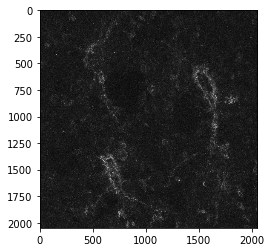

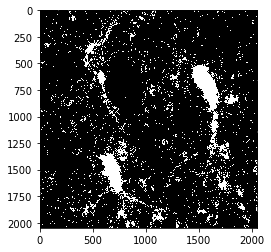

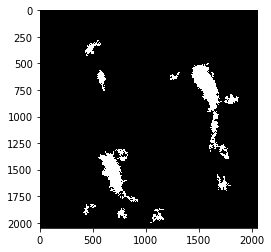

C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

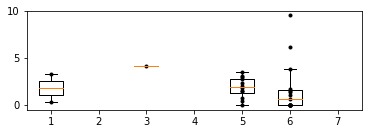

In [4]:
Deff1_binning, Deff1_plot_data, Deff1_x, Deff_1_y = PNN_binning(img, feat_df, min_obj_size=3000, feat = 'Deff1', box_plot=True)

In [5]:
feat_df

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2,Euc,Bin
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN,125.992063,5.0
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288,120.917327,5.0
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345,167.370846,6.0
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378,124.823876,5.0
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN,107.056060,5.0
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095,362.295460,6.0
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN,321.014018,6.0
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549,350.697876,6.0
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328,318.025156,6.0
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN,319.156701,6.0


C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


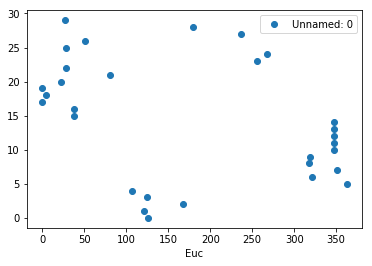

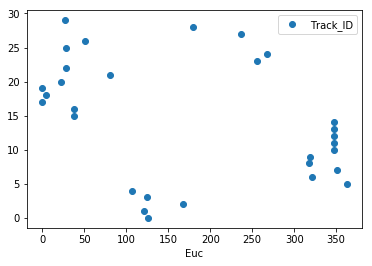

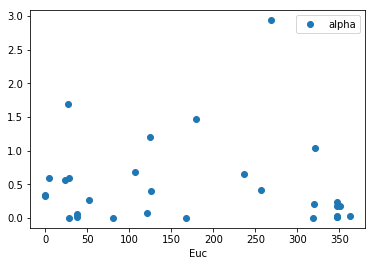

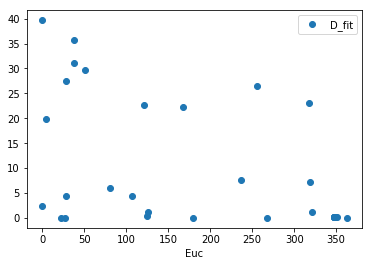

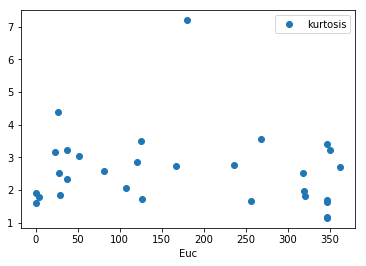

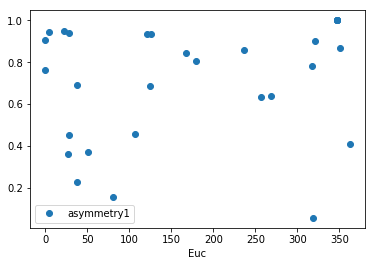

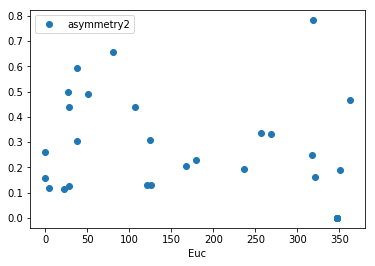

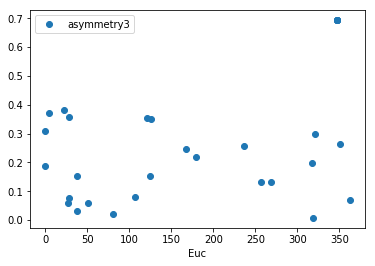

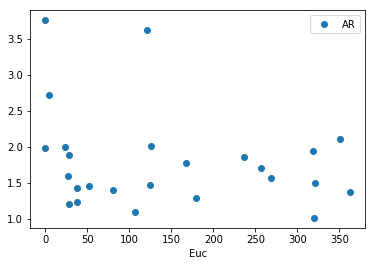

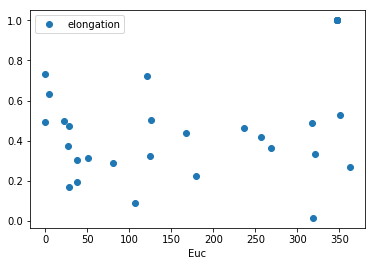

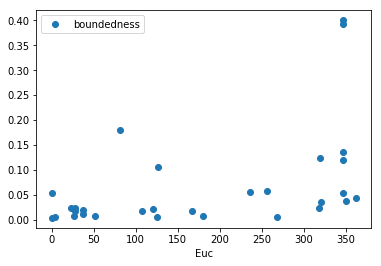

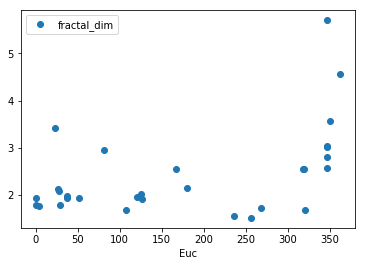

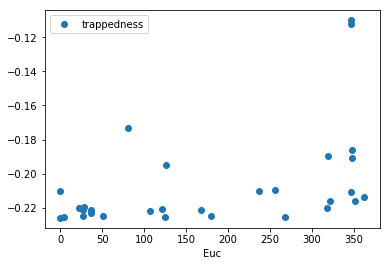

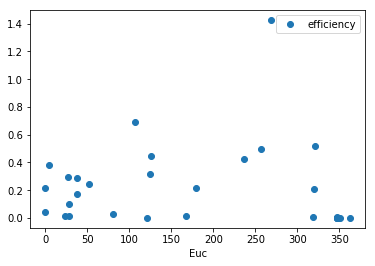

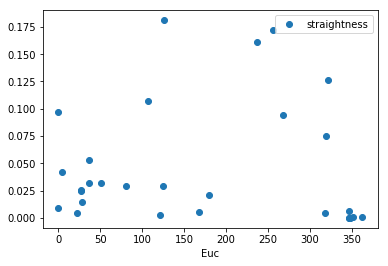

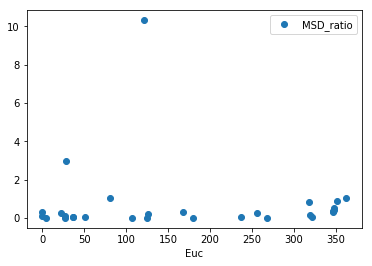

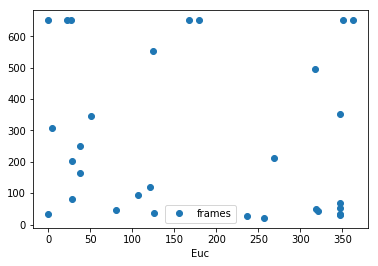

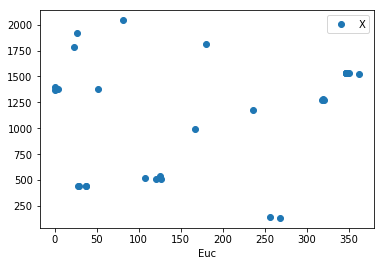

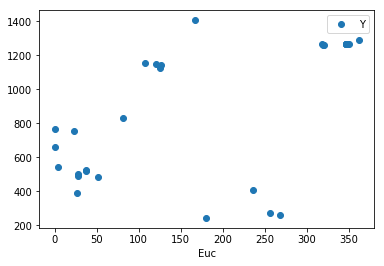

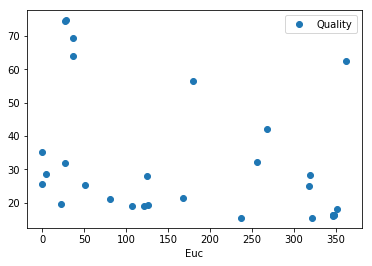

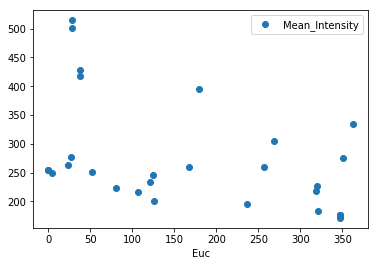

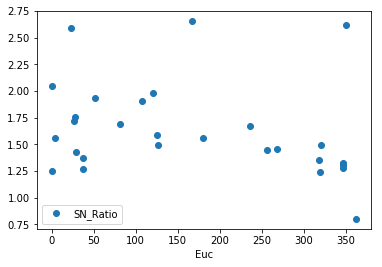

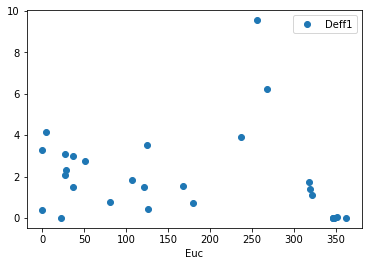

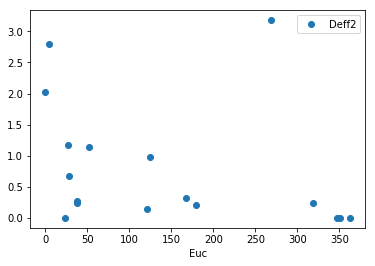

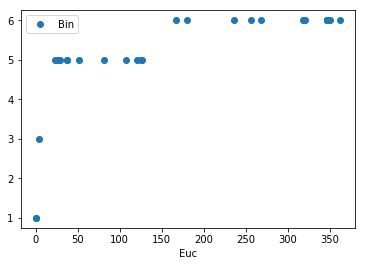

In [28]:
#Mike - all the plots of features vs. Euc

column_names = list(feat_df.columns.values)
column_names.remove('Euc')
for name in column_names: 
    feat_df.plot(x = 'Euc', y = name, style = 'o')

C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


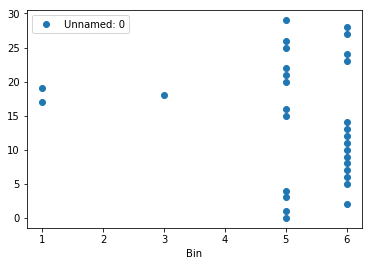

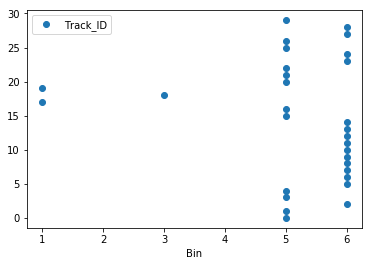

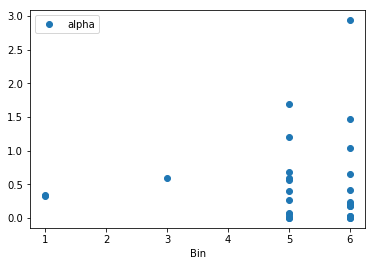

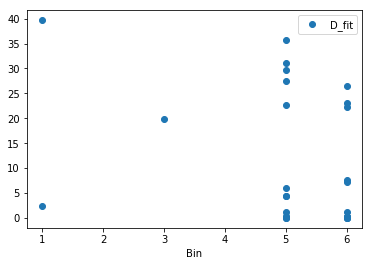

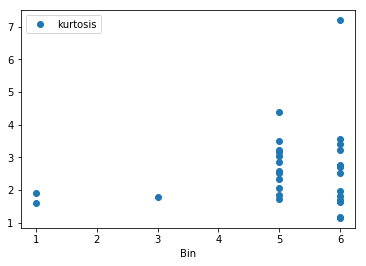

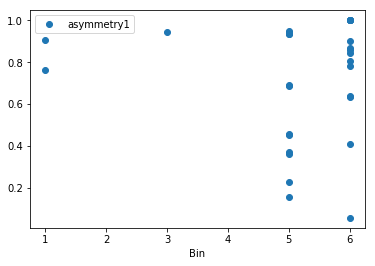

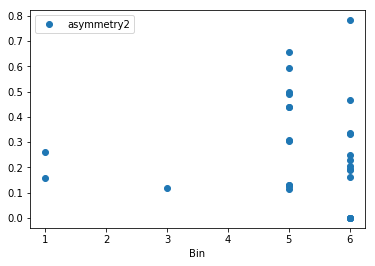

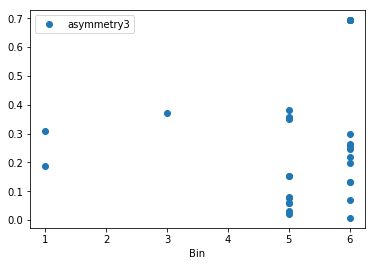

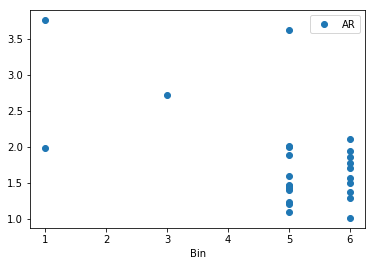

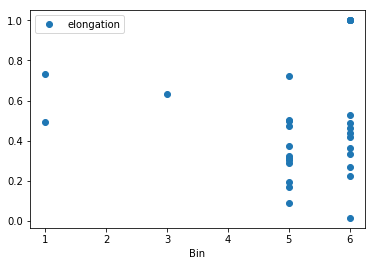

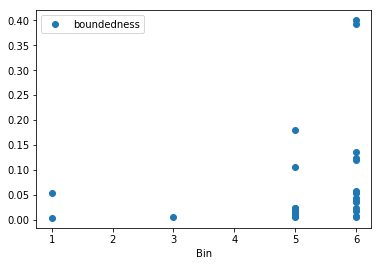

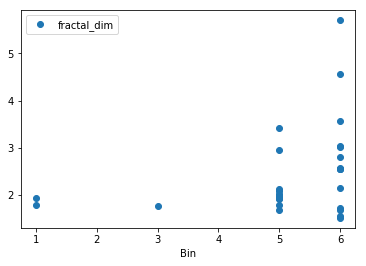

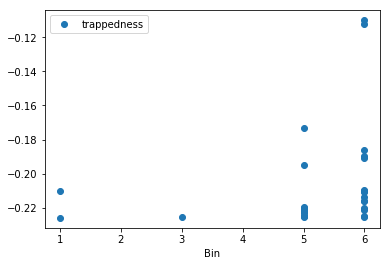

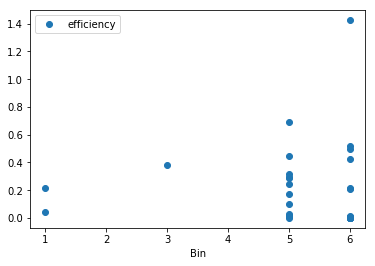

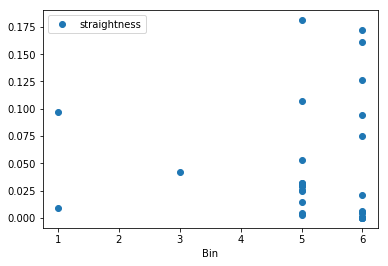

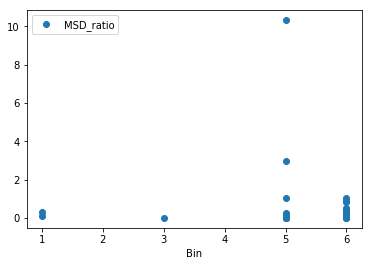

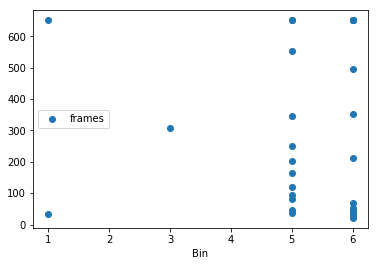

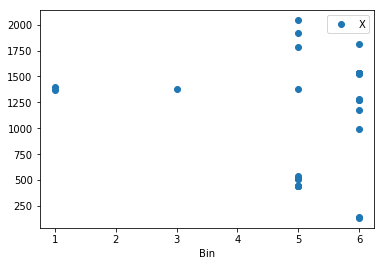

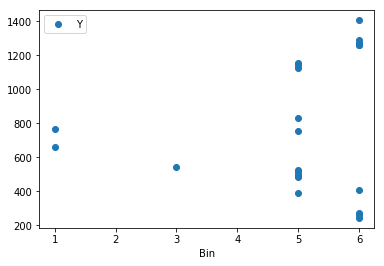

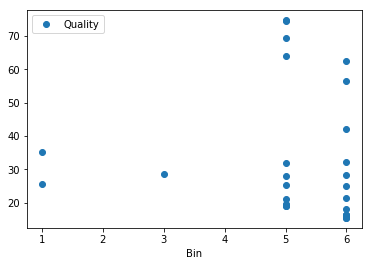

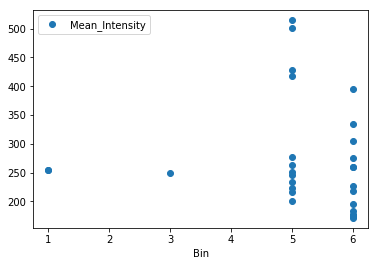

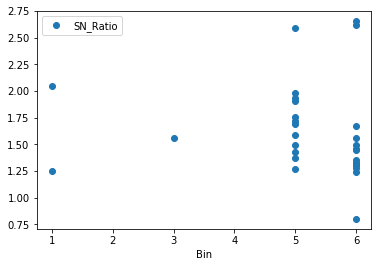

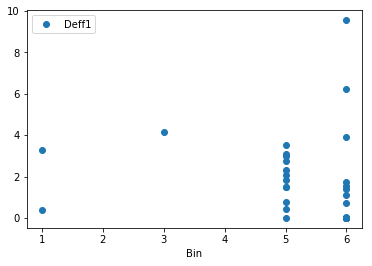

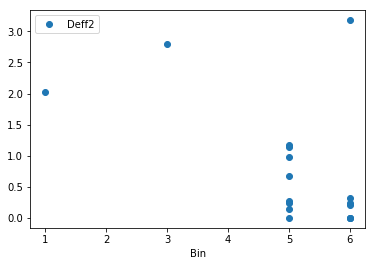

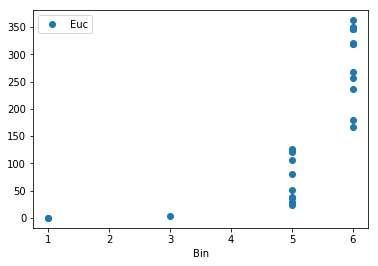

In [29]:
#Mike - all the plots of features vs. Bin

column_names = list(feat_df.columns.values)
column_names.remove('Bin')
for name in column_names: 
    feat_df.plot(x = 'Bin', y = name, style = 'o')

C:\Users\Emily\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1874: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1881: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the 

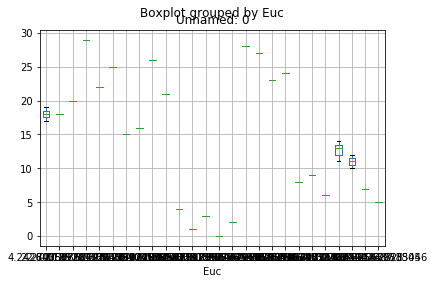

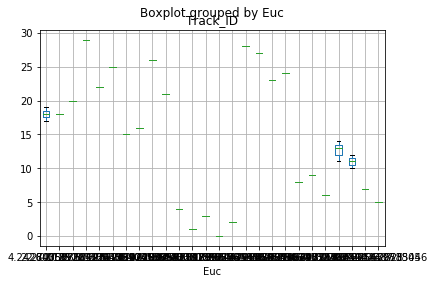

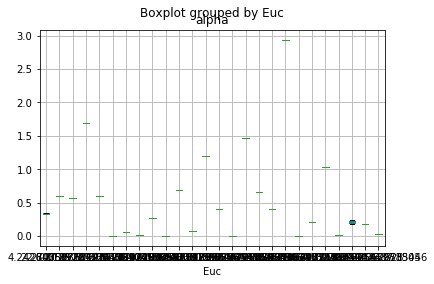

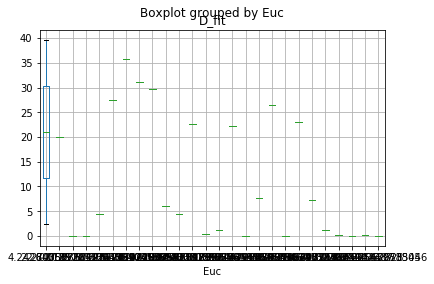

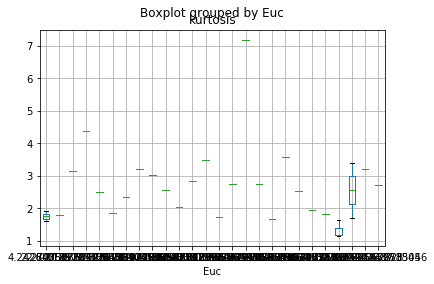

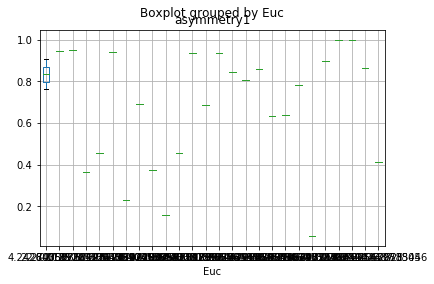

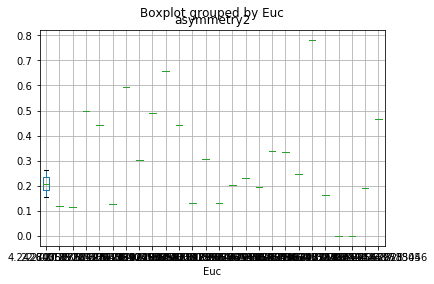

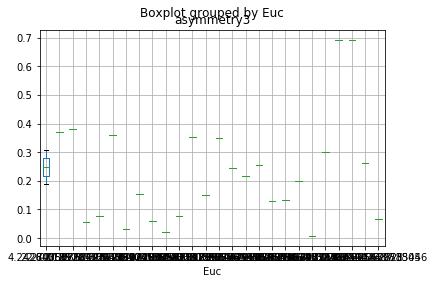

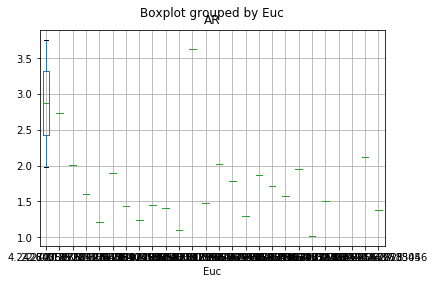

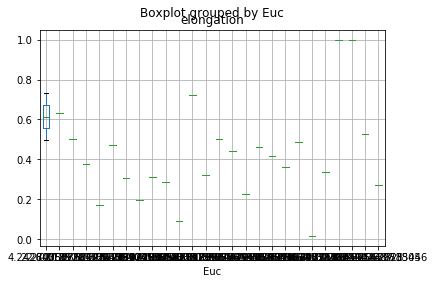

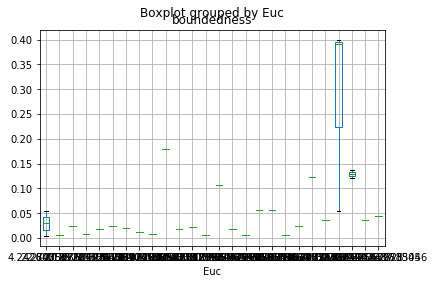

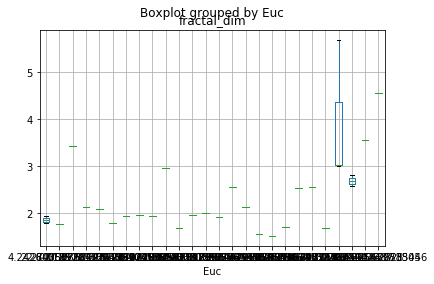

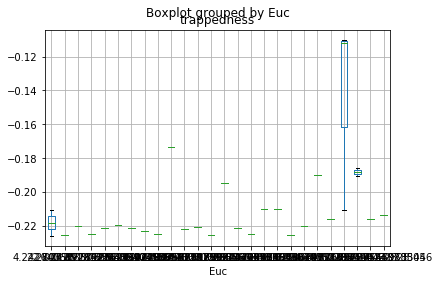

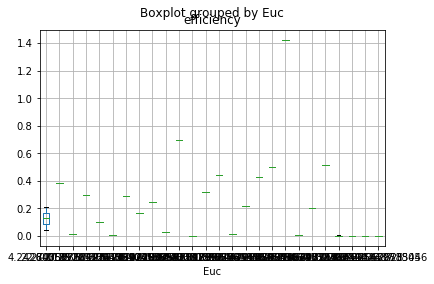

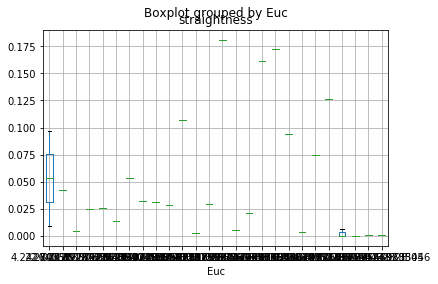

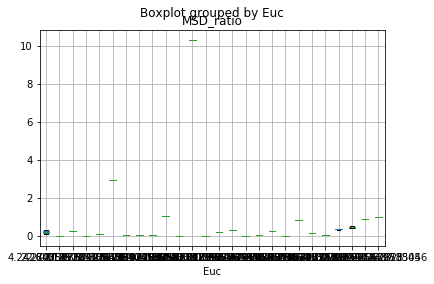

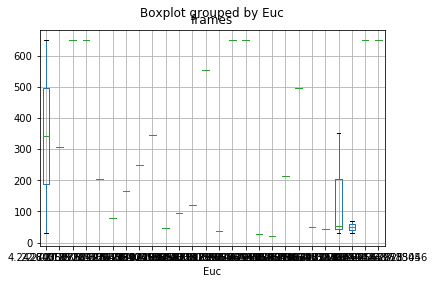

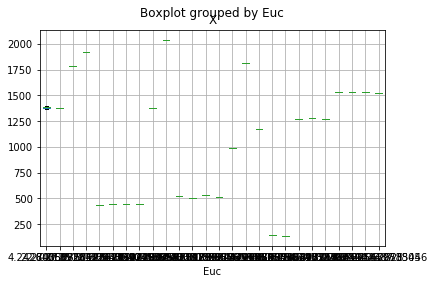

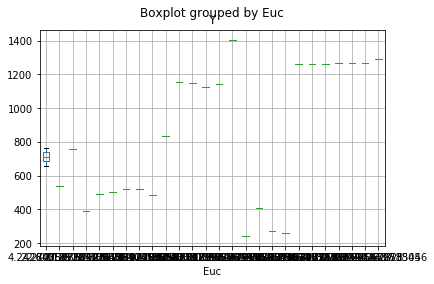

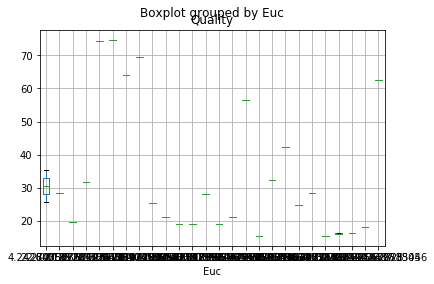

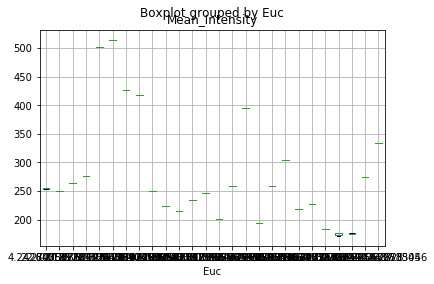

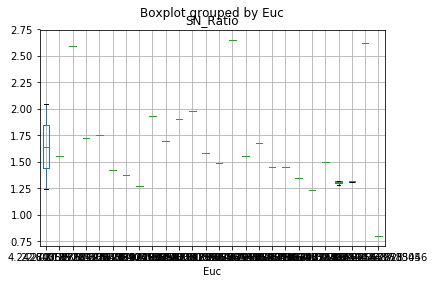

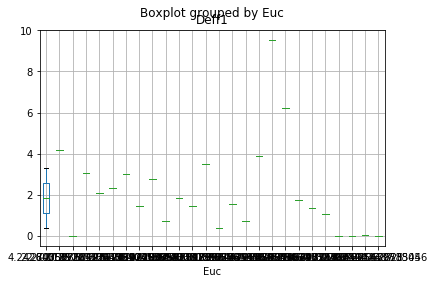

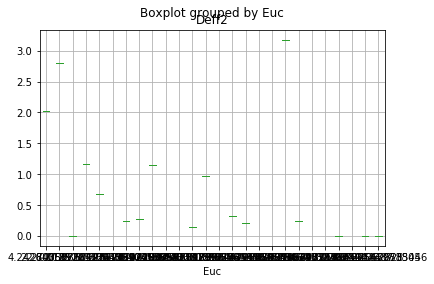

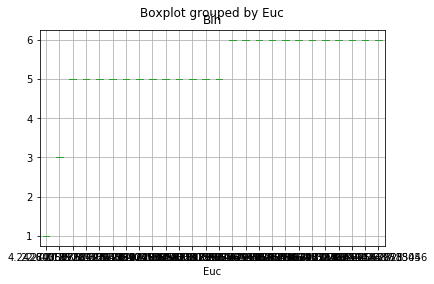

In [35]:
#Mike - all the plots of features vs. Euc (box plots) - this fails because the Eucs are not constant...

column_names = list(feat_df.columns.values)
column_names.remove('Euc')
for name in column_names: 
    feat_df.boxplot(column = [name], by = 'Euc')

C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


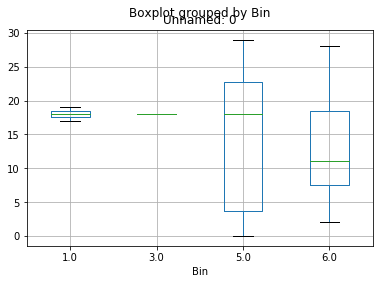

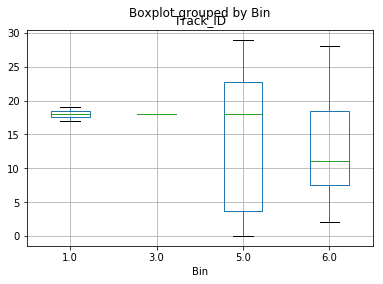

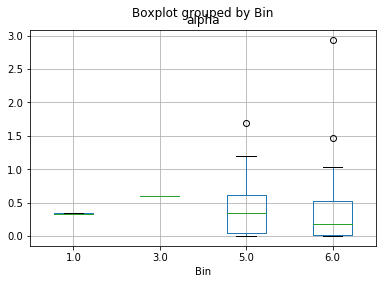

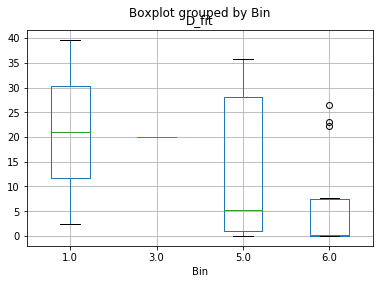

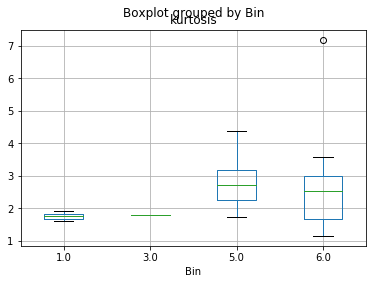

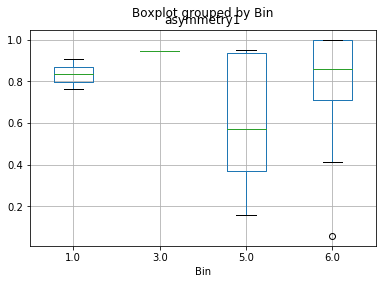

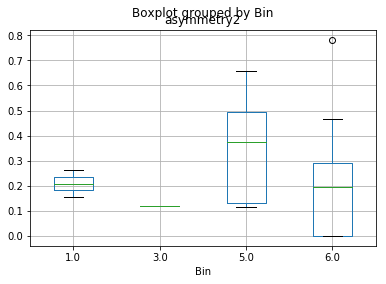

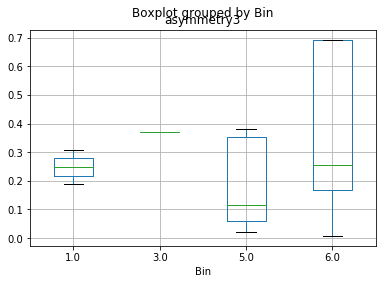

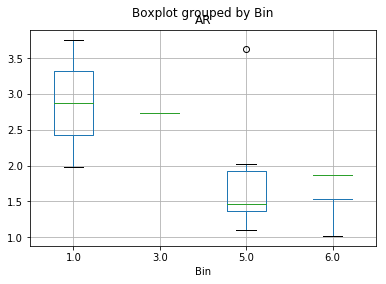

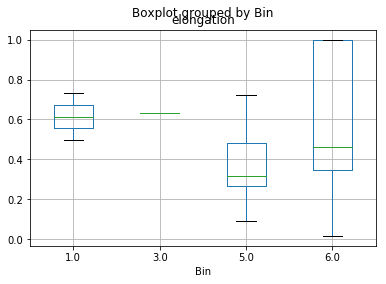

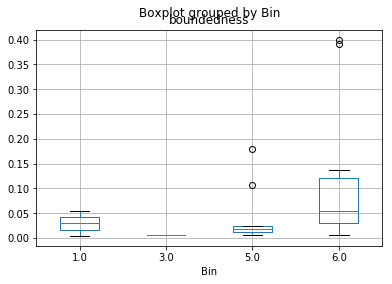

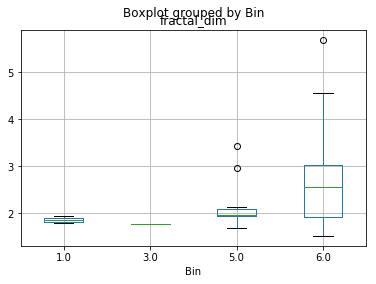

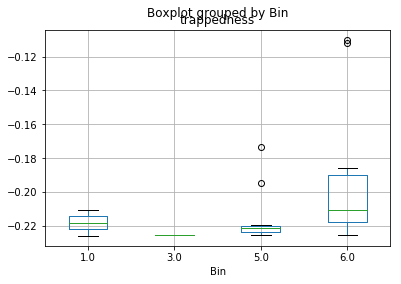

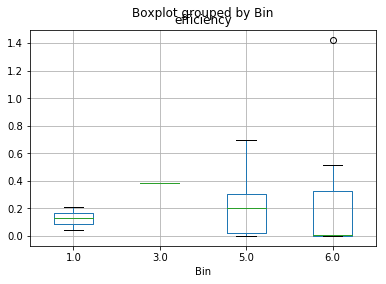

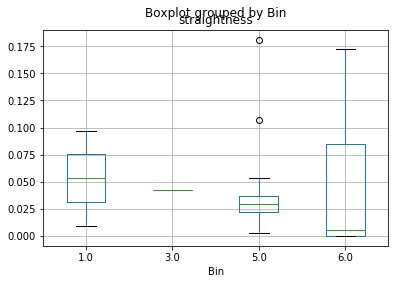

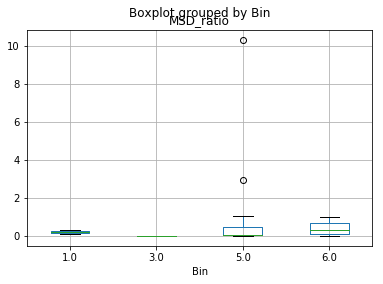

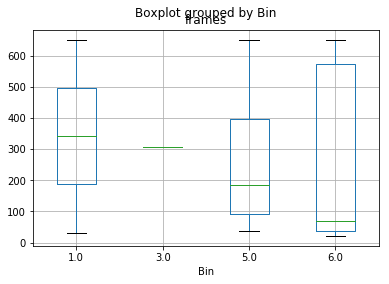

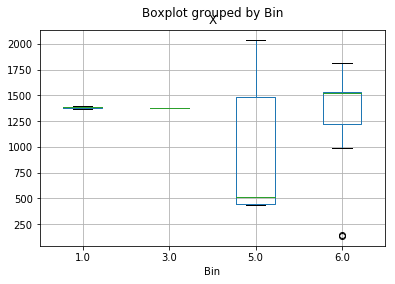

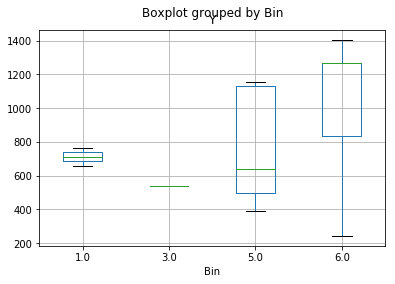

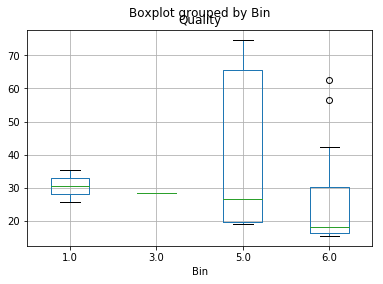

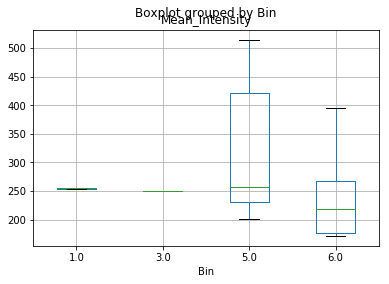

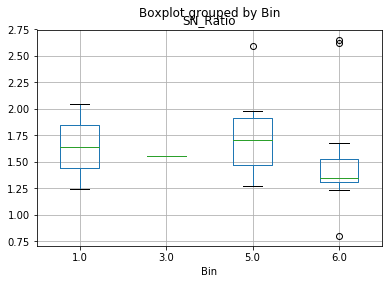

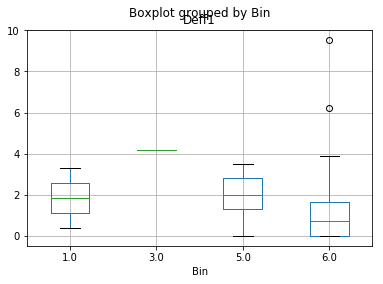

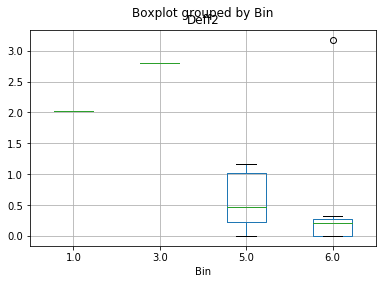

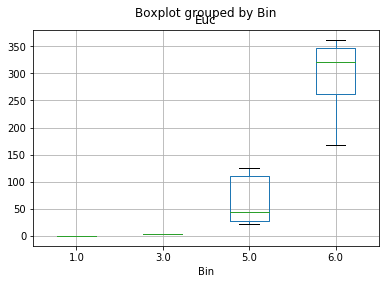

In [34]:
#Mike - all the plots of features vs. Bin (box plots)

column_names = list(feat_df.columns.values)
column_names.remove('Bin')
for name in column_names: 
    feat_df.boxplot(column = [name], by = 'Bin')
    

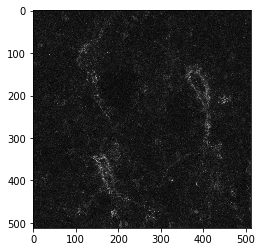

In [6]:
img.shape
imgplot = plt.imshow(img[0, :, :], cmap='gray')
plt.show()

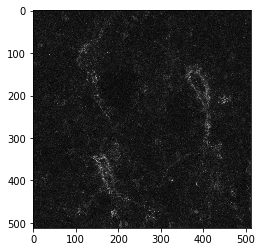

In [7]:
img = skimage.io.imread('HBSS_vid_3_z_stack_MaxIP.tif')
img.shape
imgplot = plt.imshow(img[0, :, :], cmap='gray')
plt.show()

C:\Users\Emily\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Emily\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


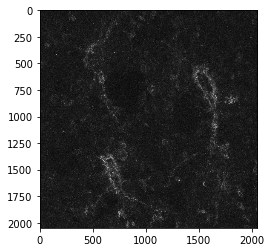

In [8]:
img_scaled = resize(img[0,:,:],(2048,2048))
scaled_plot = plt.imshow(img_scaled, cmap='gray')
#plt.axis('off')
plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 1440x1296 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000D0828BA828>,
       dtype=object))

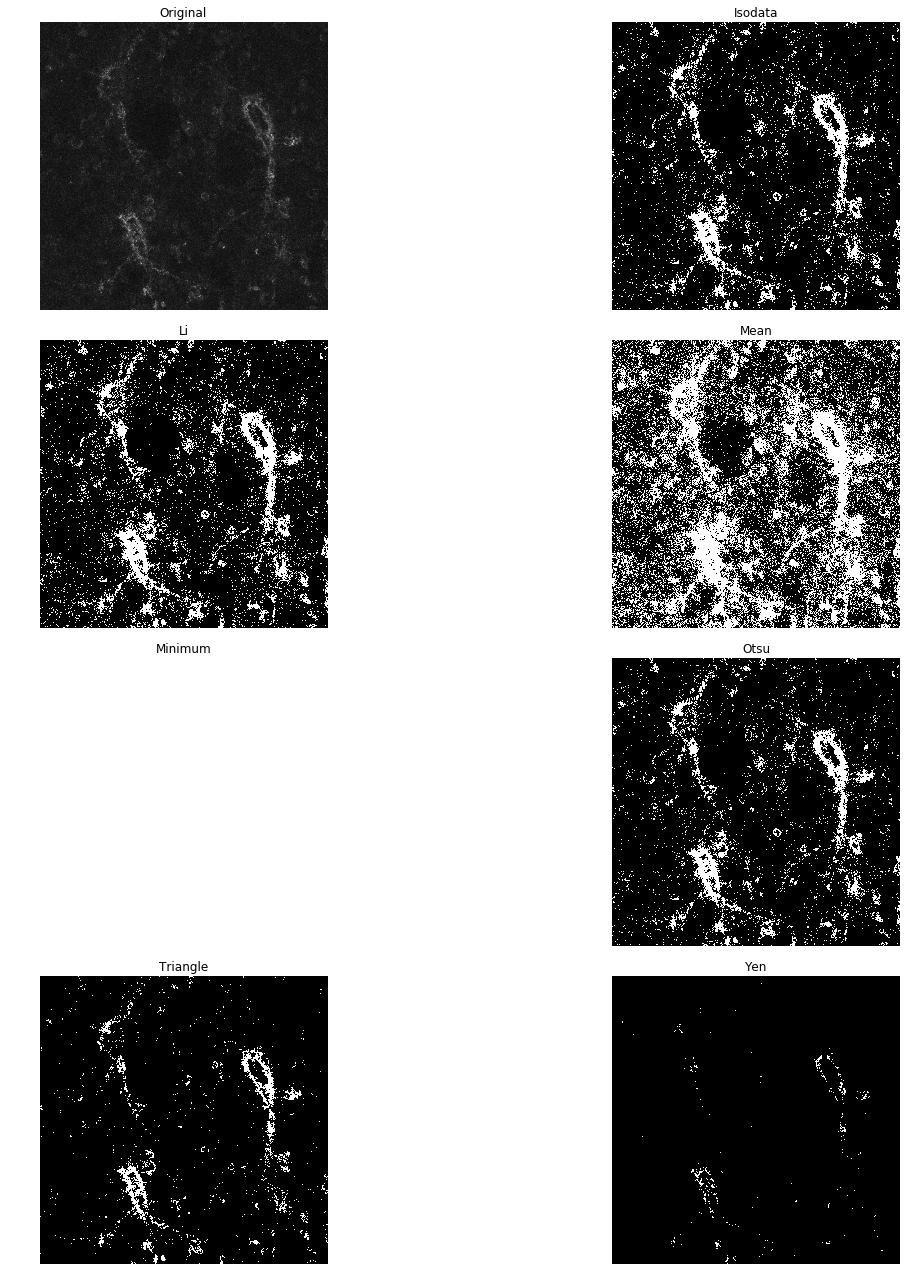

In [9]:
try_all_threshold(img_scaled, figsize=(20,18))

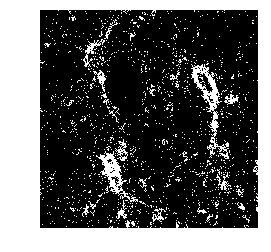

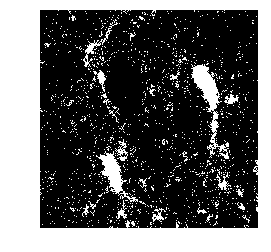

In [10]:
# This performs threshold without using a preprocessing median filtering technique

thresh = skimage.filters.threshold_otsu(img_scaled)
pnnbinary = img_scaled > thresh
binaryplot = plt.imshow(pnnbinary, cmap='gray')
plt.axis('off')
plt.show()

pnnbinary_filled = ndi.binary_fill_holes(pnnbinary)
binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
plt.axis('off')
plt.show()

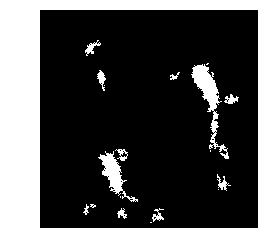

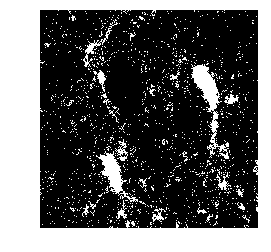

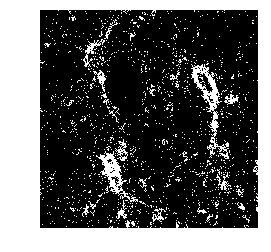

In [11]:
from skimage import morphology

pnn_clean = morphology.remove_small_objects(pnnbinary_filled, min_size=3000)
pnn_clean_plot = plt.imshow(pnn_clean, cmap='gray')
plt.axis('off')
plt.show()
binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
plt.axis('off')
plt.show()
binaryplot = plt.imshow(pnnbinary, cmap='gray')
plt.axis('off')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

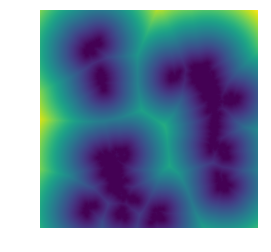

In [12]:
from scipy.ndimage.morphology import distance_transform_edt as Euclidean

euc_img = Euclidean(1-pnn_clean) #1- represents going outwards from the cells
plt.imshow(euc_img)
plt.axis('off')
plt.show

In [13]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "msd_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
local_name = filename
merged = pd.read_csv(local_name)

In [14]:
merged[0:10]

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity
0,0,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,1,1.0,0.0,NaN,NaN,4.001641,2.396512,NaN,NaN,NaN
2,2,2.0,0.0,NaN,NaN,6.834146,1.681477,NaN,NaN,NaN
3,3,3.0,0.0,NaN,NaN,7.851303,1.606836,NaN,NaN,NaN
4,4,4.0,0.0,NaN,NaN,8.840694,1.439491,NaN,NaN,NaN
5,5,5.0,0.0,NaN,NaN,11.364362,1.123226,NaN,NaN,NaN
6,6,6.0,0.0,NaN,NaN,12.743154,1.025701,NaN,NaN,NaN
7,7,7.0,0.0,NaN,NaN,14.829385,0.891548,NaN,NaN,NaN
8,8,8.0,0.0,NaN,NaN,15.837694,0.879375,NaN,NaN,NaN
9,9,9.0,0.0,NaN,NaN,16.595764,0.835129,NaN,NaN,NaN


In [15]:
merged['Euc'] = np.nan
merged[0:10]

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity,Euc
0,0,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,1.0,0.0,NaN,NaN,4.001641,2.396512,NaN,NaN,NaN,NaN
2,2,2.0,0.0,NaN,NaN,6.834146,1.681477,NaN,NaN,NaN,NaN
3,3,3.0,0.0,NaN,NaN,7.851303,1.606836,NaN,NaN,NaN,NaN
4,4,4.0,0.0,NaN,NaN,8.840694,1.439491,NaN,NaN,NaN,NaN
5,5,5.0,0.0,NaN,NaN,11.364362,1.123226,NaN,NaN,NaN,NaN
6,6,6.0,0.0,NaN,NaN,12.743154,1.025701,NaN,NaN,NaN,NaN
7,7,7.0,0.0,NaN,NaN,14.829385,0.891548,NaN,NaN,NaN,NaN
8,8,8.0,0.0,NaN,NaN,15.837694,0.879375,NaN,NaN,NaN,NaN
9,9,9.0,0.0,NaN,NaN,16.595764,0.835129,NaN,NaN,NaN,NaN


In [16]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "features_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
feat_name = filename
feat_df = pd.read_csv(feat_name)

In [17]:
feat_df
feat_df['Euc'] = np.nan
feat_df['Bin'] = np.nan
feat_df[0:10]

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2,Euc,Bin
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN,NaN,NaN
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288,NaN,NaN
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345,NaN,NaN
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378,NaN,NaN
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN,NaN,NaN
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095,NaN,NaN
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN,NaN,NaN
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549,NaN,NaN
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328,NaN,NaN
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN,NaN,NaN


In [18]:
tot_traj = int(max(feat_df['Track_ID']))
one_count = 0
two_count = 0
three_count = 0
four_count = 0
five_count = 0
six_count = 0
seven_count = 0


for i in range(0,tot_traj+1):
    feat_df['Euc'][i] = euc_img[int(round(feat_df['X'][i])),int(round(feat_df['Y'][i]))]
    
    if feat_df['Euc'][i] == 0:
        feat_df['Bin'][i] = 1
        one_count = one_count+1
    elif feat_df['Euc'][i] <= 3.57: # 250 nm
        feat_df['Bin'][i] = 2
        two_count = two_count+1
    elif feat_df['Euc'][i] <= 7.14: # 500 nm
        feat_df['Bin'][i] = 3
        three_count = three_count+1
    elif feat_df['Euc'][i] <= 14.28: # 1 um
        feat_df['Bin'][i] = 4
        four_count = four_count+1
    elif feat_df['Euc'][i] <= 142.8: # 10 um
        feat_df['Bin'][i] = 5
        five_count = five_count+1
    elif feat_df['Euc'][i] <= 714.3: # 50 um
        feat_df['Bin'][i] = 6
        six_count = six_count+1
    else:
        feat_df['Bin'][i] = 7
        seven_count = seven_count+1

C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a 

In [19]:
print(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)
print(int(max(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)))

2 0 1 0 12 15 0
15


In [20]:
feat_df[['Track_ID','D_fit','X','Y','frames','Deff1','Euc','Bin']]
#feat_df['Track_ID']['D_fit'][0:10]

,Track_ID,D_fit,X,Y,frames,Deff1,Euc,Bin
0,0.0,1.234418,509.015730,1142.000000,37.0,0.408862,125.992063,5.0
1,1.0,22.602545,506.762867,1151.349323,121.0,1.475014,120.917327,5.0
2,2.0,22.318937,992.308138,1406.011083,651.0,1.542021,167.370846,6.0
3,3.0,0.315534,534.741736,1124.659826,552.0,3.505944,124.823876,5.0
4,4.0,4.453814,524.004213,1153.821478,95.0,1.853615,107.056060,5.0
5,5.0,0.008623,1527.849205,1289.100075,651.0,0.000802,362.295460,6.0
6,6.0,1.144086,1273.056117,1260.794551,44.0,1.090887,321.014018,6.0
7,7.0,0.173863,1531.519726,1266.492676,651.0,0.028056,350.697876,6.0
8,8.0,23.080683,1274.293518,1264.200154,496.0,1.749976,318.025156,6.0
9,9.0,7.290224,1280.257552,1263.243048,51.0,1.385392,319.156701,6.0


In [21]:
num_bins = 7
summary_array = np.zeros((int(max(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)), int(num_bins)))

tot_traj = int(max(feat_df['Track_ID']))
count_one = 0
count_two = 0
count_three = 0
count_four = 0
count_five = 0
count_six = 0
count_seven = 0

for i in range(0,tot_traj+1):
    if feat_df['Bin'][i] == 1:
        summary_array[count_one, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_one = count_one + 1
    elif feat_df['Bin'][i] == 2:
        summary_array[count_two, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_two = count_two + 1
    elif feat_df['Bin'][i] == 3:
        summary_array[count_three, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_three = count_three + 1
    elif feat_df['Bin'][i] == 4:
        summary_array[count_four, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_four = count_four + 1
    elif feat_df['Bin'][i] == 5:
        summary_array[count_five, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_five = count_five + 1
    elif feat_df['Bin'][i] == 6:
        summary_array[count_six, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_six = count_six + 1
    else:
        summary_array[count_seven, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_seven = count_seven + 1
    
print(summary_array)

masked_summary = ma.masked_where(summary_array == 0, summary_array)
plot_array = [[y for y in row if y] for row in masked_summary.T]
print(plot_array)



[[3.28548086e+00 0.00000000e+00 4.15829772e+00 0.00000000e+00
  4.08862130e-01 1.54202129e+00 0.00000000e+00]
 [3.88768643e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.47501428e+00 8.01664724e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.50594437e+00 1.09088665e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.85361461e+00 2.80562153e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.99207891e+00 1.74997617e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.48051507e+00 1.38539226e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.39719288e-03 1.25000000e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.46316558e-01 1.33720930e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.08514340e+00 1.07142857e-02 0.00000000e+00]
 [0.000000

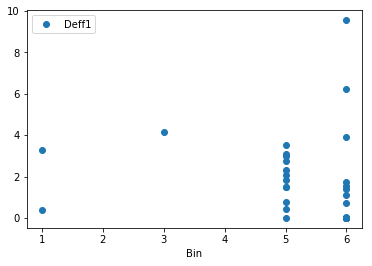

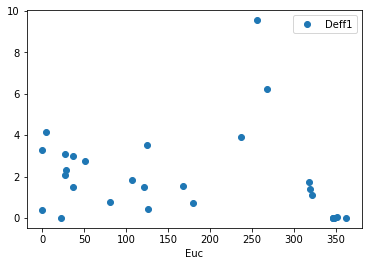

In [23]:
feat_df.plot(x = 'Bin', y = 'Deff1', style = 'o')
feat_df.plot(x = 'Euc', y = 'Deff1', style = 'o')

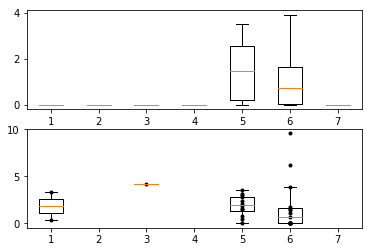

In [20]:
x = np.zeros(tot_traj+1)
y = np.zeros(tot_traj+1)

p = 0
for i in range(np.size(plot_array)):
    for j in range(len(plot_array[i])):
        x[p] = i+1
        y[p] = plot_array[i][j]
        p = p + 1

plt.subplot(211)
plt.boxplot(summary_array, sym = '')
plt.subplot(212)
plt.boxplot(plot_array, showfliers = False)
plt.plot(x,y,'k.')
plt.show()